### 1. Разбиваем файл с твитами на тренировочную, валидационную и тестовую выборки

In [1]:
from src.data_utils import process_text

process_text('./data/')

Обработка текста...


100%|██████████| 1600498/1600498 [00:10<00:00, 156257.99it/s]



Перемешиваем данные...
Размер тренировочного набора: 1280398 ( 80.0%)
Размер валидационного набора: 160050 ( 10.0%)
Размер тестового набора: 160050 ( 10.0%)

Сохраняем разделенные датасеты...
Тренировочный набор сохранен в: ./data/train.csv
Валидационный набор сохранен в: ./data/val.csv
Тестовый набор сохранен в: ./data/test.csv


### 2. Тренируем собственную модель

Для начала импортируем все необходимые модули

In [2]:
import os
import random

import pandas as pd
import torch
from transformers import AutoTokenizer

from src.data_utils import split_text_3_4
from src.eval_lstm import generate_and_evaluate
from src.lstm_model import SimpleLSTM
from src.lstm_train import train_model_with_rouge
from src.next_token_dataset import create_dataloader


Загрузим датасеты и создадим даталоадеры

In [3]:
data_dir = './data/'

# Создаем директорию для чекпоинтов
save_directory = "checkpoints"
os.makedirs(save_directory, exist_ok=True)

# Загружаем токенизатор
print('Загрузка токенизатора...')
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Добавляем специальные токены для начала/конца
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

print('Загрузка тренировочного датасета...')
train_data = pd.read_csv(f'{data_dir}train.csv')
train_texts = (
    train_data['tweet'] if 'tweet' in train_data.columns
    else train_data.iloc[:, 0]
)

print('Загрузка валидационного датасета...')
val_data = pd.read_csv(f'{data_dir}val.csv')
val_texts = (
    val_data['tweet'] if 'tweet' in val_data.columns
    else val_data.iloc[:, 0]
)

print('Загрузка тестового датасета...')
test_data = pd.read_csv(f'{data_dir}val.csv')
texts = test_data['tweet'].dropna().tolist()
selected_texts = random.sample(texts, 10)

# Создаем Dataloader'ы
print('Создание даталоадеров...')
train_dataloader = create_dataloader(train_texts, tokenizer)
val_dataloader = create_dataloader(val_texts, tokenizer)

# Определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

Загрузка токенизатора...
Загрузка тренировочного датасета...
Загрузка валидационного датасета...
Загрузка тестового датасета...
Создание даталоадеров...
Количество батчей в dataloader: 5002

Пример батча:
input_ids shape: torch.Size([256, 36])
attention_mask shape: torch.Size([256, 36])
labels shape: torch.Size([256, 36])

Пример данных (первые 2 элемента батча):

Элемент 0: 
Вход: babydollniki homagawd i can t deal with mess so my room s always tidy i m having a mental breakdown cause i need to vaccuum t
Цель: ##dollniki homagawd i can t deal with mess so my room s always tidy i m having a mental breakdown cause i need to vaccuum t t

Элемент 1: 
Вход: it s hot amp i can t
Цель: s hot amp i can t sleep
Количество батчей в dataloader: 626

Пример батча:
input_ids shape: torch.Size([256, 40])
attention_mask shape: torch.Size([256, 40])
labels shape: torch.Size([256, 40])

Пример данных (первые 2 элемента батча):

Элемент 0: 
Вход: lyss i m sorry it doesn t sound like you had a very good

Запустим процесс обучения модели с периодическим измерением метрик на валидационной выборке (после каждой эпохи) и сохранением показателей в память TrainHistory для постраения графиков.


Модель создана:
  Параметров: 12,672,570
  Размер словаря: 30522
Начинаем обучение на cpu...
Размер словаря: 30522


Epoch 1/5 [Train]: 100%|██████████| 5002/5002 [4:20:55<00:00,  3.13s/it, loss=5.2624, avg_loss=10.3760, lr=0.001000] 



Epoch 1/5 завершена


Генерация текста: 100%|██████████| 10/10 [00:00<00:00, 13.80it/s]


'dreambig i sang that with two of my friends for graduation exactly years ago today makes me' -> 'dreambig i sang that with two of my friends for graduation exactly years ago today makes me i m not going to be a good day i m going to be a good night i m going'
'suzannadanna praying it all' -> 'suzannadanna praying it all of you i m so excited for the show i m going to be a good mood i m going'
'smaloy i m just helping out and tour manage them hopefully a bigger' -> 'smaloy i m just helping out and tour manage them hopefully a bigger of the day i m going to be a good time i m going to miss my baby and i'
'sad that my princess is' -> 'sad that my princess is i m so tired i m so tired i m so tired i m so tired i m so tired'
'terri xoxo hell yeah ugggh how' -> 'terri xoxo hell yeah ugggh how i do i have to go to work today i m so tired i m going to miss my baby'
'we r goin home in' -> 'we r goin home in of the sun and i m going to be a good night i m so happy i m going to'
'this is why i l

Epoch 2/5 [Train]: 100%|██████████| 5002/5002 [4:14:06<00:00,  3.05s/it, loss=4.9483, avg_loss=9.1754, lr=0.001000]  



Epoch 2/5 завершена


Генерация текста: 100%|██████████| 10/10 [00:00<00:00, 11.82it/s]


'dreambig i sang that with two of my friends for graduation exactly years ago today makes me' -> 'dreambig i sang that with two of my friends for graduation exactly years ago today makes me i m so sad i can t wait for the next season of the hills finale i m so excited'
'suzannadanna praying it all' -> 'suzannadanna praying it all and i m not sure what i m doing well i m not sure if i can get a new'
'smaloy i m just helping out and tour manage them hopefully a bigger' -> 'smaloy i m just helping out and tour manage them hopefully a bigger of the day i m going to miss the beach and the sun is shining and i m not going'
'sad that my princess is' -> 'sad that my princess is on the phone with me and my mom is going to be a good day at work and i m'
'terri xoxo hell yeah ugggh how' -> 'terri xoxo hell yeah ugggh how you do that i m not sure i m not a fan of the year i m not sure i'
'we r goin home in' -> 'we r goin home in of the day i m going to miss the sunshine and the sun is shining and 

Epoch 3/5 [Train]: 100%|██████████| 5002/5002 [4:12:40<00:00,  3.03s/it, loss=5.0028, avg_loss=8.8698, lr=0.001000]  



Epoch 3/5 завершена


Генерация текста: 100%|██████████| 10/10 [00:00<00:00, 13.82it/s]


'dreambig i sang that with two of my friends for graduation exactly years ago today makes me' -> 'dreambig i sang that with two of my friends for graduation exactly years ago today makes me of it i m so excited for the next one i m gonna miss you guys so much i love'
'suzannadanna praying it all' -> 'suzannadanna praying it all up with the fam and i m not going to be able to get my new phone and i'
'smaloy i m just helping out and tour manage them hopefully a bigger' -> 'smaloy i m just helping out and tour manage them hopefully a bigger of the day is over and i m not going to be able to get a new one i m'
'sad that my princess is' -> 'sad that my princess is i m going to miss the beach and i m not going to be able to get a new phone'
'terri xoxo hell yeah ugggh how' -> 'terri xoxo hell yeah ugggh how is that i m not going to be able to get a new phone but i m not sure if'
'we r goin home in' -> 'we r goin home in i m going to miss the beach and i m not going to be able to get a new ph

Epoch 4/5 [Train]: 100%|██████████| 5002/5002 [4:12:53<00:00,  3.03s/it, loss=4.8547, avg_loss=8.6991, lr=0.001000]  



Epoch 4/5 завершена


Генерация текста: 100%|██████████| 10/10 [00:00<00:00, 11.86it/s]


'dreambig i sang that with two of my friends for graduation exactly years ago today makes me' -> 'dreambig i sang that with two of my friends for graduation exactly years ago today makes me of you i m so happy for you i m so happy for you i m so happy for you'
'suzannadanna praying it all' -> 'suzannadanna praying it all up with a lot of people who have been so busy lately i m not going to be able to'
'smaloy i m just helping out and tour manage them hopefully a bigger' -> 'smaloy i m just helping out and tour manage them hopefully a bigger of the day is over and i m not sure what to do with my job i m so tired'
'sad that my princess is' -> 'sad that my princess is i m going to miss my best friend and i m going to miss the seniors i m going to'
'terri xoxo hell yeah ugggh how' -> 'terri xoxo hell yeah ugggh how is that i m not a fan of the game i m so sad i can t wait to see'
'we r goin home in' -> 'we r goin home in i m going to miss my best friend and i m going to miss the seniors i 

Epoch 5/5 [Train]: 100%|██████████| 5002/5002 [4:12:41<00:00,  3.03s/it, loss=4.7446, avg_loss=8.5836, lr=0.001000]  



Epoch 5/5 завершена


Генерация текста: 100%|██████████| 10/10 [00:00<00:00, 11.42it/s]


'dreambig i sang that with two of my friends for graduation exactly years ago today makes me' -> 'dreambig i sang that with two of my friends for graduation exactly years ago today makes me of you i m so happy for you i m so happy for you i m so happy for you'
'suzannadanna praying it all' -> 'suzannadanna praying it all up with a new one http bit ly zxcxo i m sorry i m not'
'smaloy i m just helping out and tour manage them hopefully a bigger' -> 'smaloy i m just helping out and tour manage them hopefully a bigger of the day is going to be a good day for me to be in the office for a few'
'sad that my princess is' -> 'sad that my princess is i m going to miss the new moon trailer i love it when i get home i m going to'
'terri xoxo hell yeah ugggh how' -> 'terri xoxo hell yeah ugggh how is it going to be a good day i m going to miss the beach and the sun is shining'
'we r goin home in' -> 'we r goin home in i m so tired and i m not going to be able to get my new phone and i can'
'this is

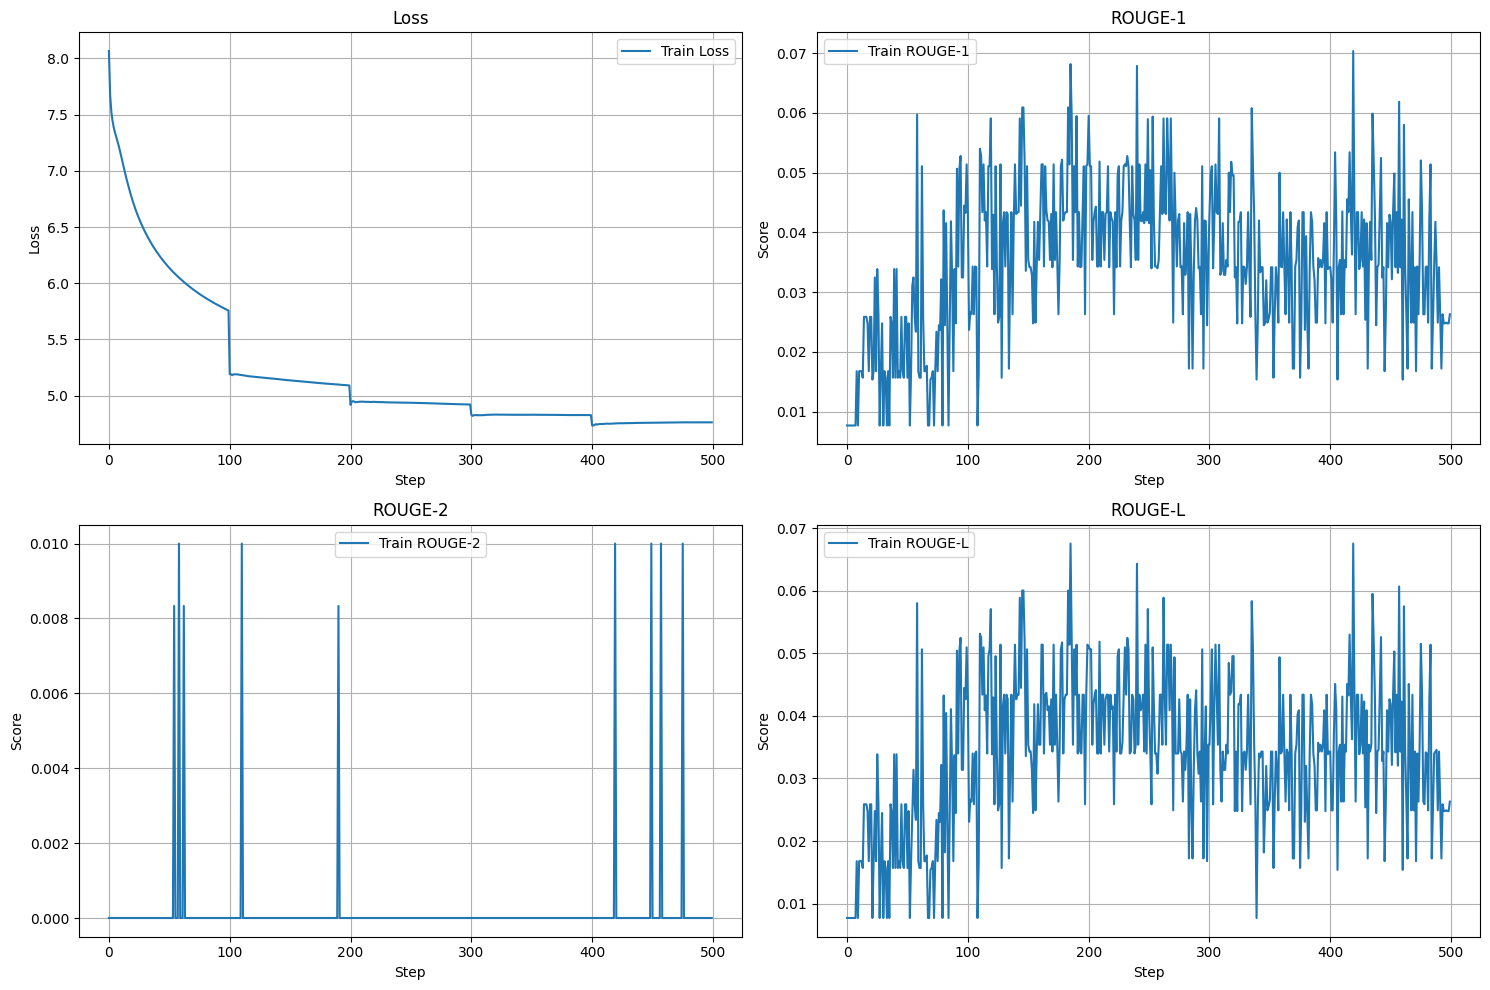


Финальная оценка модели:


Генерация текста: 100%|██████████| 10/10 [00:01<00:00,  9.72it/s]


'dreambig i sang that with two of my friends for graduation exactly years ago today makes me' -> 'dreambig i sang that with two of my friends for graduation exactly years ago today makes me of you i m so happy for you i m so happy for you i m so happy for you'
'suzannadanna praying it all' -> 'suzannadanna praying it all up with a new one http bit ly zxcxo i m sorry i m not'
'smaloy i m just helping out and tour manage them hopefully a bigger' -> 'smaloy i m just helping out and tour manage them hopefully a bigger of the day is going to be a good day for me to be in the office for a few'
'sad that my princess is' -> 'sad that my princess is i m going to miss the new moon trailer i love it when i get home i m going to'
'terri xoxo hell yeah ugggh how' -> 'terri xoxo hell yeah ugggh how is it going to be a good day i m going to miss the beach and the sun is shining'
'we r goin home in' -> 'we r goin home in i m so tired and i m not going to be able to get my new phone and i can'
'this is

In [4]:
# Создаем модель
vocab_size = len(tokenizer)
model = SimpleLSTM(
    vocab_size=vocab_size,
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2
)

print(f"\nМодель создана:")
print(f"  Параметров: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Размер словаря: {vocab_size}")

# Обучаем модель
trained_model, history = train_model_with_rouge(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    selected_texts=selected_texts,
    tokenizer=tokenizer,
    device=device,
    num_epochs=5,
    learning_rate=0.001,
    eval_every=50,  # Каждые 50 шагов
    save_dir=save_directory,
)

# Визуализируем историю обучения
history.plot_training_history()

# Финальная оценка
print("\n" + "=" * 60)
print("Финальная оценка модели:")
print("=" * 60)

prompts = []
references = []
for text in selected_texts:
    split_data = split_text_3_4(text, tokenizer)
    prompts.append(split_data['prompt'])
    references.append(split_data['target'])

results = generate_and_evaluate(
    model, tokenizer, prompts, references, device,
)
for key, value in results.items():
    print(f"{key}: {value:.4f}")